# C7.3 Computational & Digital Holography

Zweig Wong

huangzw29@mail2.sysu.edu.cn

2022-06-19

## Computational Holography
reference: https://github.com/JackHCC/Computer-Generated-Hologram

In [22]:
from PIL import Image
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display

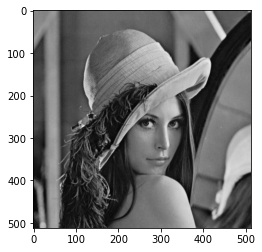

In [3]:
image = Image.open("Test/lena.png", mode="r").convert("L") # Convert to Gray and 
image =image.resize((512, 512), Image.BILINEAR) # resize
plt.imshow(image, cmap="gray")

In [18]:
class GS:
    def __init__(self, image):
        self.raw_image = np.array(image)
        self.width, self.height = self.raw_image.shape[0], self.raw_image.shape[1]
        self.amplitude = self.norm_amplitude()
        self.phase = 2 * np.pi * np.random.rand(self.width, self.height)
        # Initial complex amplitude
        self.complex_amplitude = self.amplitude * np.exp(1j * self.phase)
        self.RMSE = None
        # Phrase hologram result
        self.phase_result = None
        self.result = None

    def norm_amplitude(self):
        return self.raw_image / np.max(self.raw_image)

    def train(self, epoch=500):
        self.RMSE = np.zeros(epoch)
        for i in tqdm(range(epoch)):
            # Reverse Fourier Transform to get the frequency domain image
            freq_img = ifft2(fftshift(self.complex_amplitude))
            # Phrase hologram result
            f_img_phase = np.angle(freq_img)
            f_img_norm = self.amplitude * np.exp(1j * f_img_phase)
            # Fourier Transform to get the space domain image
            space_img = fft2(fftshift(f_img_norm))
            error = np.abs(self.amplitude) - fftshift(np.abs(space_img) / np.max(space_img))
            self.RMSE[i] = np.sqrt(np.mean(np.power(error, 2)))
            # Feed back
            self.complex_amplitude = np.abs(self.amplitude) * (space_img / np.abs(space_img))
        self.phase_result = np.abs(f_img_phase)
        self.result = np.abs(fftshift(space_img))


        plt.figure(0)
        plt.imshow(self.raw_image, cmap="gray")
        
        # Phrase hologram
        plt.figure(1)
        plt.imshow(self.phase_result, cmap="gray")
        plt.axis("off")
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.savefig("Test/lena_phase.png", bbox_inches = 'tight', dpi=300, pad_inches=0, transparent=True)
        # Simulated reconstructed image
        plt.figure(2)
        plt.axis("off")
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.imshow(self.format_image(self.result), cmap="gray")
        plt.savefig("Test/lena_reconstructed_sim.png", bbox_inches = 'tight', dpi=300, pad_inches=0, transparent=True)
        # plt.figure(3)
        # plt.plot(list(range(epoch)), self.RMSE)
        # plt.show()

    def format_image(self, img):
        img = img * 255 / np.max(img)
        img = img.astype(np.uint8)
        return img

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\12977\AppData\Local\Temp/ipykernel_10844/3716617430.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  self.RMSE[i] = np.sqrt(np.mean(np.power(error, 2)))
100%|██████████| 500/500 [00:49<00:00, 10.08it/s]


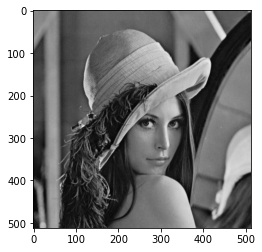

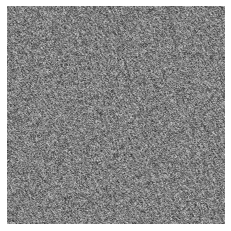

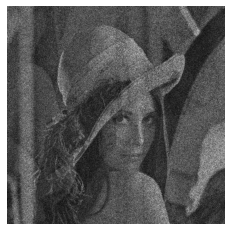

In [19]:
GS(image).train()

## Digital holography

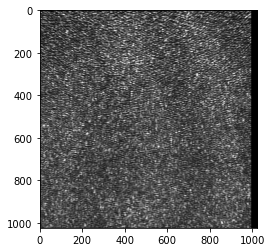

In [44]:
# Read the hologram image file
hologram = Image.open('Test/dice_holo.BMP', mode="r")
hologram = np.array(hologram).astype(np.float64) 
plt.imshow(hologram, cmap="gray")

In [45]:
# User defined reconstruction distance
w = widgets.FloatSlider(value=-1.054,min=-2.0,max=2.0,step=0.001,
description='d (in meters):',orientation='horizontal',readout=True,readout_format='.3f',)
display(w)

FloatSlider(value=-1.054, description='d (in meters):', max=2.0, min=-2.0, readout_format='.3f', step=0.001)

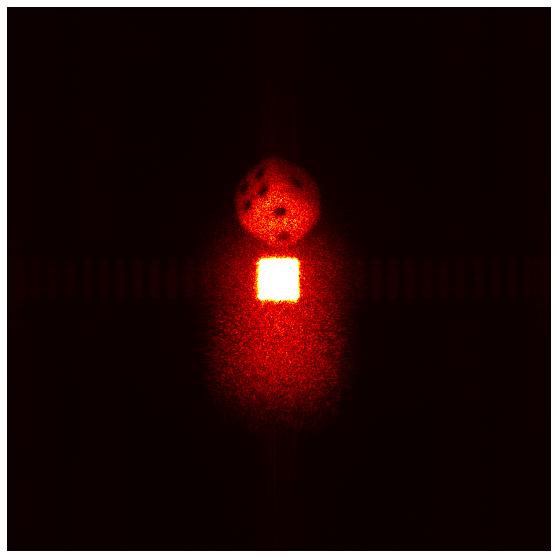

In [47]:
# User define parameters
Nr,Nc = np.shape(hologram) #number of rows and columns in the hologram
wavelength = 632.8e-9 #HeNe laser wavelength in SI units i.e. meters
dx = 6.8e-6 #sensor pixel size in meters
d = 1 #-1.054 #reconstruction distance in meters

# prepare the Fresnel operand for the hologram
Nr = np.linspace(0, Nr-1, Nr)-Nr/2
Nc = np.linspace(0, Nc-1, Nc)-Nc/2 
k, l = np.meshgrid(Nc,Nr)
factor = np.multiply(hologram, np.exp(-1j*np.pi/(wavelength*d)*(np.multiply(k, k)*dx**2 + np.multiply(l, l)*dx**2)))
reconstructed_field = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(factor))) # Take inverse Fourier transform of the factor
# plot
I = np.abs(reconstructed_field)/np.max(np.abs(reconstructed_field)) #normalized intensity profile
fig = plt.figure(figsize=(10,10)) #setup a blank figure 
plt.imshow(I, cmap="hot", clim=(0.0, 0.3))
# plt.colorbar()
plt.axis("off")
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("Test/dice_reconstructed.png", bbox_inches = 'tight', dpi=300, pad_inches=0, transparent=True)